In [434]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [435]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.  # landing platform height
w1 = [-PLATFORM_WIDTH, PLATFORM_WIDTH]
w2 = [0.1*-PLATFORM_WIDTH, 0.1*PLATFORM_WIDTH]
h = [PLATFORM_HEIGHT, PLATFORM_HEIGHT]
ROTATION_ACCEL = np.radians(20)  # rotation constant

In [436]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])
        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1)

        return state

In [437]:
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [438]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state(N)
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state(n):
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [0.5*math.pi*(random.random()-0.5), 0.1*math.pi*(random.random()-0.5), # orientation state
                     (random.random()-0.5), 0.1*(random.random()-0.5), # horizontal state
                     0.5*random.random()+1, -0.1*random.random()]  # vertical state
        print('Generate %d initial states of rocket:' % n)
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 1.0]) # weight of each state
        return states.sum(dim=0)

In [439]:
class Evaluation:
    def __init__(self, simulation):
        self.simulation = simulation

    def test(self, n):
        loss = self.simulation(self.simulation.state)
        print('total loss: %.5f' % loss)
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        print('Landing Trajectory:')
        for r in range(n):
            plt.quiver(data[:,r, 2], data[:,r, 4], -0.05*np.sin(data[:,r, 0]), 0.05*np.cos(data[:,r, 0]))
            plt.quiver(data[-1,r, 2], data[-1,r, 4], -0.05*np.sin(data[-1,r, 0]), 0.05*np.cos(data[-1,r, 0]),color='orange')
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.show()
            end = data[-1,r,:]
            print(np.abs(end))

Generate 20 initial states of rocket:
[[ 1.57540944e-01  4.37083934e-02 -2.93418555e-02 -1.29531568e-02
   1.32738833e+00 -8.91049315e-02]
 [ 4.18630783e-01  9.86350286e-02 -1.75264755e-01  2.09248191e-02
   1.10013329e+00 -5.29888061e-03]
 [-2.14263233e-01 -5.10726441e-02 -3.99576848e-01  1.80373035e-02
   1.31727447e+00 -9.68706710e-02]
 [-1.59382149e-01 -9.52580860e-02  3.94486930e-02 -4.69094029e-02
   1.36414892e+00 -1.22008288e-02]
 [-3.16324496e-01 -8.21857887e-02  2.47229351e-01 -1.71891257e-02
   1.19717671e+00 -3.21584750e-02]
 [ 5.69139531e-01 -1.31064963e-01 -3.00880413e-01  2.92259455e-02
   1.15897166e+00 -8.41154173e-02]
 [ 4.02237765e-01 -8.92999862e-02 -2.77698349e-01 -4.75032018e-02
   1.39612839e+00 -5.60139435e-02]
 [-1.41314615e-01  5.09134260e-02  1.55467629e-01  2.63259778e-02
   1.42074751e+00 -5.79170900e-02]
 [ 3.77552312e-01 -1.41811064e-02 -1.91141647e-01 -2.67086777e-04
   1.25682984e+00 -9.36477250e-02]
 [ 3.38452286e-01 -2.66533379e-02  2.68447653e-01  9.

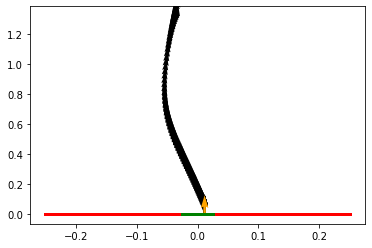

[2.4742744e-04 6.9589310e-05 1.1487791e-02 4.1763968e-04 9.5447620e-05
 1.1121482e-04]


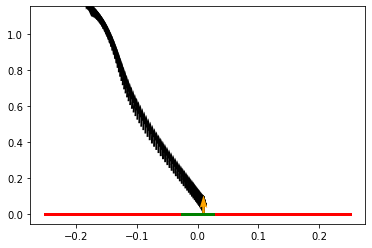

[3.73652379e-04 1.21855745e-04 9.69543774e-03 3.94857285e-04
 6.84513725e-05 1.79189257e-04]


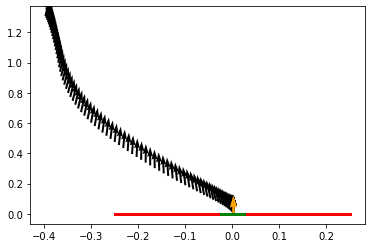

[6.1349926e-04 1.2333480e-04 2.4447341e-03 2.3190089e-04 1.9240142e-05
 3.4856703e-04]


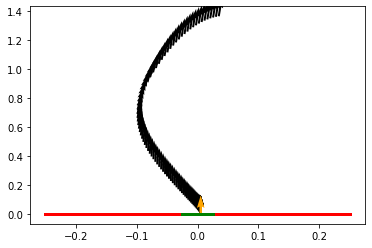

[3.9226236e-04 7.4237888e-04 5.1354282e-03 3.0110151e-04 1.9841249e-05
 2.6094727e-04]


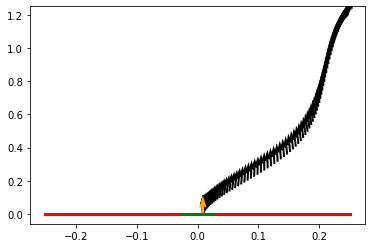

[7.3055533e-05 5.6593504e-04 8.6729452e-03 2.0459549e-04 5.0708058e-04
 4.3475721e-04]


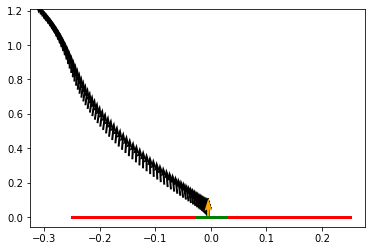

[4.54992376e-04 1.57094473e-04 4.65094857e-03 6.05037749e-05
 1.81400130e-04 1.21966936e-04]


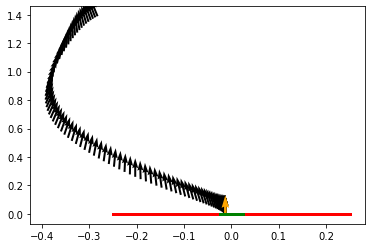

[6.0371886e-04 8.3835400e-04 1.2678104e-02 4.3388008e-04 9.3978070e-07
 3.5674591e-04]


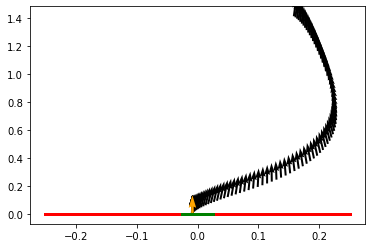

[0.00235996 0.00124223 0.00848821 0.00059518 0.00051489 0.00018402]


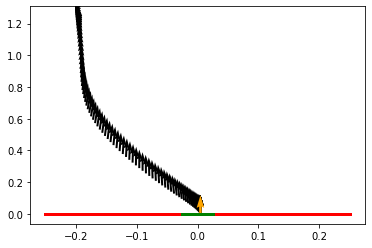

[0.00018657 0.00032238 0.00462817 0.00022225 0.00013247 0.00015663]


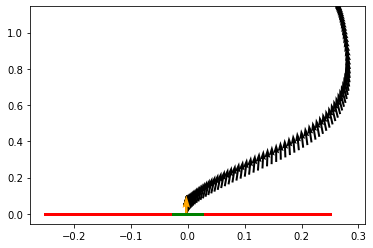

[2.3562321e-04 3.5913492e-04 2.4654090e-03 5.5362118e-05 3.5496560e-04
 1.3164431e-04]


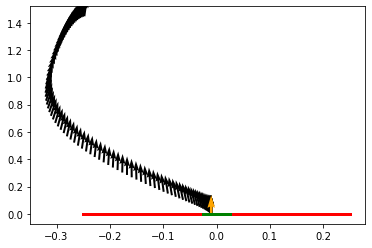

[6.7073898e-04 1.4245692e-03 9.9648945e-03 9.9818477e-05 2.8695696e-04
 4.4063758e-04]


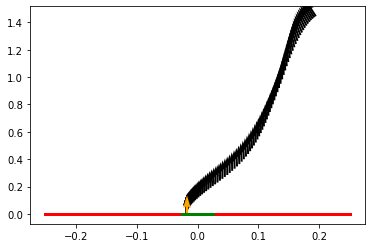

[0.0009638  0.00024294 0.01752649 0.00047284 0.00023658 0.00017262]


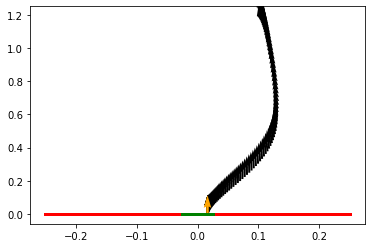

[0.00046646 0.00044766 0.01625828 0.00034684 0.00050988 0.00056557]


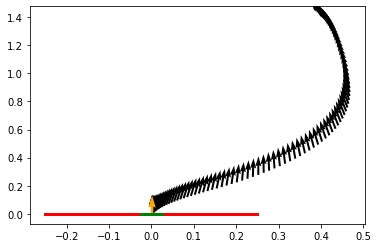

[3.9986652e-04 1.8890109e-04 1.4331663e-03 2.6787771e-04 7.3363612e-05
 1.0370854e-03]


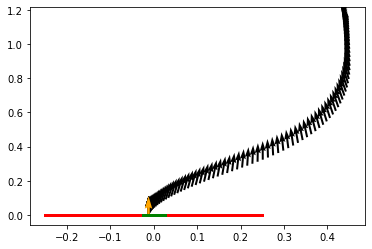

[8.9603208e-04 1.1357983e-03 1.2341514e-02 1.8766837e-04 6.7381829e-05
 3.9543957e-04]


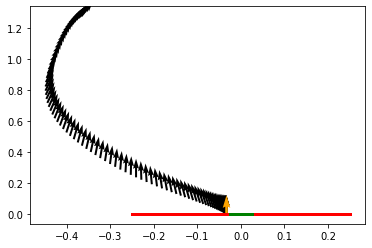

[0.0018494  0.00360413 0.03306937 0.00146321 0.00020311 0.00041183]


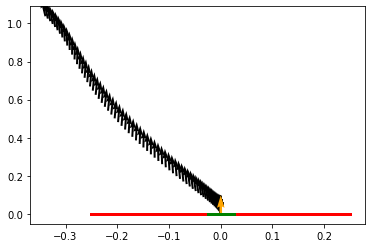

[4.5089130e-04 2.6406680e-04 3.6447699e-04 9.7139666e-05 2.0347349e-04
 8.5561536e-05]


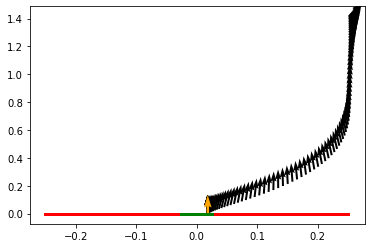

[6.4568026e-03 1.0637471e-02 1.8575963e-02 6.9134796e-05 4.8885366e-04
 5.4366514e-04]


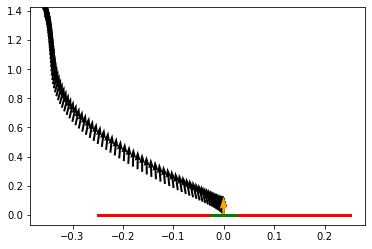

[0.00012609 0.00024937 0.00033646 0.00012498 0.00026445 0.00065007]


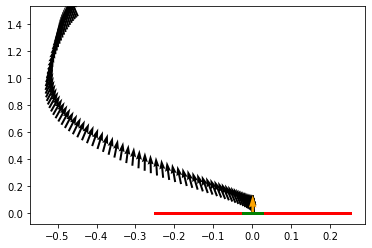

[0.00412642 0.03021834 0.00074616 0.00011551 0.00188846 0.00402333]


In [440]:
N_eval = 20 # number of initial states for testing
T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d_eval = Dynamics()  # define dynamics
model_eval =  Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)

path = './Landing_Model.pth'
model_eval.load_state_dict(t.load(path))
model_eval.eval()

s_eval = Simulation(model_eval, d_eval, T, N_eval )
eva = Evaluation(s_eval)  # define optimizer
eva.test(N_eval)

